In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean
import pickle
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
city = 'Bhopal'
month = 'July'
PATH = f'./../../Item_wise_data/{city}/'
# PATH = './../'


In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

/tmp/ipykernel_216807/70406848.py:2: DtypeWarning: Columns (5,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH+f'{month}.csv')


In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)


(156415, 29)
(156415, 10)


In [5]:
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = (df['prep_time']/np.timedelta64(1, 's')).astype(float)
print(df.shape)
df.head()

(156415, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [6]:
isThresholdForPreparationTime = True
thresholdForPreparationTimeUpper = 15 # minutes for preparation time (threshold)
thresholdForPreparationTimeLower = 0 # minutes for lowest preparation time (threshold)
df2 = pd.DataFrame()
if (isThresholdForPreparationTime):
    df = df.loc[(df['prep_time'] <= thresholdForPreparationTimeUpper*60) & \
        (df['prep_time'] >= thresholdForPreparationTimeLower*60) ]
print(df.shape)
df.head()

(156186, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [7]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]

Delivery_Time           0.039062
Location_Code           0.000000
Order_Date              0.000000
Order_Number            0.000000
Driver_Shift            0.000000
Kitchen_Display_Time    0.000000
Oven_Time               0.000000
Menu_Code               0.000000
Item Description        0.000000
Quantity                0.000000
prep_time               0.000000
dtype: float64

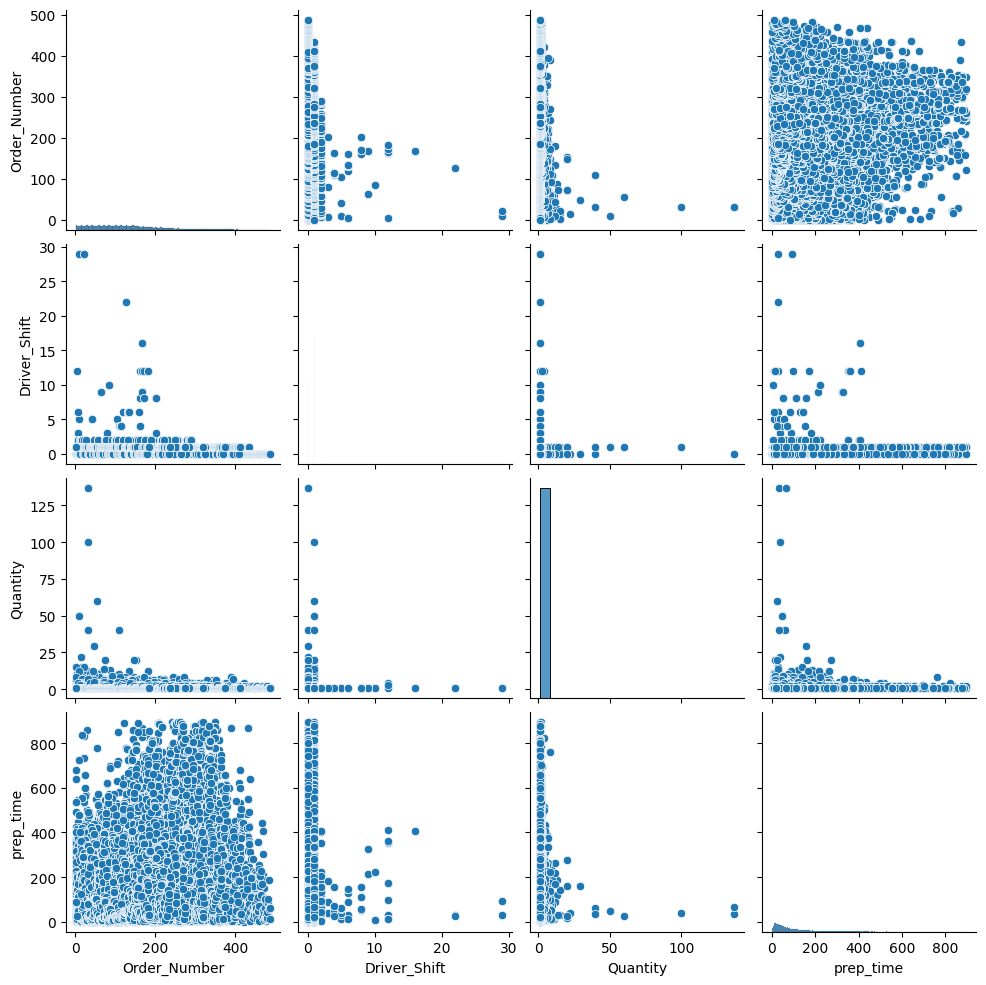

In [8]:
sns.pairplot(data=df)

<Axes: >

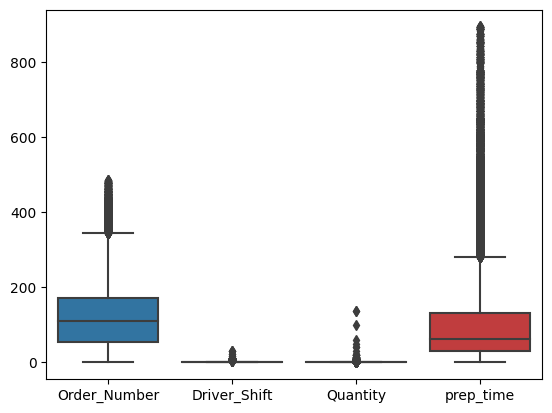

In [9]:
sns.boxplot(df)

In [10]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()
# allMenuCodes,
# allStoreIds
print(len(allMenuCodes))
print(len(allStoreIds))

146
12


In [11]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = df.loc[df['Location_Code'] == storeId]

In [12]:
def get_preparation_time(item):
    return item['prep_time']

In [13]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [14]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if stores[i] == storeId:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        for i in range(0, len(allStoreIds)):
            if item['Location_Code'] == allStoreIds[i]:
                return [i+1]
        return [-1]

In [15]:
# Feature 2 : Day of the week
def dayOfTheWeek(dt, isOneHotEncodingRequired=False):
    day = dt.weekday()
    if isOneHotEncodingRequired:
        days = [0, 0, 0, 0, 0, 0, 0]
        days[day] = 1
        return days
    else:
        return [day+1]

In [16]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

[1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if (isOneHotEncodingRequired):
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [1+timeslot]

In [18]:
# Feature 4: Item Type
def getOneHotEncodedItemList(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodedItemList(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if items[i] == item:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, clubCategoryWise=False, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodedItemList(item['Menu_Code'], allMenuCodes, clubCategoryWise)
    else:
        for i in range(0, len(allMenuCodes)):
            if allMenuCodes[i] == item['Menu_Code']:
                return [i+1]
        print("DANGER DANGER DANGER \n\n\n")
        return [-1]

In [19]:
print(getItemType(sampleItem, False, True))
print(getItemType(sampleItem, True, False))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]


In [20]:
# Feature 5 : Count of all baking items of all orders received by the store in the last 30 minutes.

def countPastOrders(item, slotTime=30):
    storeId = item['Location_Code']
    df = restWiseDFs[storeId]
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=slotTime)
    return len(df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
          (df['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [21]:
# Feature 6: ratio of items in last 30 minutes with items in the window of last 60 to 30 minutes (increment in orders)
def getLiftInOrders(item, slotTime = 30):
    a = countPastOrders(item, slotTime)
    item2 = item
    item2['Kitchen_Display_Time'] = item2['Kitchen_Display_Time'] - timedelta(minutes=slotTime)
    b = countPastOrders(item2, slotTime)
    if b != 0:
        return a/b
    else:
        return 1


In [88]:
# TIME CONSUMING (4 m 14 seconds for Bhopal)
# Feature 7 : Avg prep time of the same item in the same store in last 60 minutes.
# Feature 8 : Avg prep time of the same item in the same store in last 7 days.
for storeId in restWiseDFs:
    avgPrepTime = restWiseDFs[storeId]['prep_time'].mean()    
    restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
    restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
    restWiseDFs[storeId]['hourswise_avg_kpt'] = 0
    for index, item in restWiseDFs[storeId].iterrows():
        itemCode = item['Menu_Code']
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTimeMinutes = dtKitchenDisplay - timedelta(minutes=60)
        lastTime = dtKitchenDisplay - timedelta(days=7)
        df3 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= lastTime) & \
                     (restWiseDFs[storeId]['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (restWiseDFs[storeId]['Menu_Code'] == itemCode)]
        df2 = df3.loc[df3['Kitchen_Display_Time'] >= lastTimeMinutes]
        if len(df2.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] = df2['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] =  avgPrepTime
        if len(df3.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] = df3['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] =  avgPrepTime


/tmp/ipykernel_216807/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_216807/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_216807/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [89]:
def getPreviousPrepTime(item, timeslot = 60):
    if timeslot == 60:
        return item['avg_kpt_in_last_one_hour']
    elif timeslot == 7*24*60:
        return item['avg_kpt_in_last_7_days']
    else:
        itemCode = item['Menu_Code']
        df = restWiseDFs[item['Location_Code']]

        dtKitchenDisplay = item['Kitchen_Display_Time']

        lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)

        df2 = df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
                     (df['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (df['Menu_Code'] == itemCode)]
        if len(df2.index) != 0:
            return df2['prep_time'].mean()
        else:
            return restWiseDFs[storeId]['prep_time'].mean()

In [90]:
# Hourwise avg
# Feature 9 : Avg prep time of the same item in same store : hour wise + according to the day of the week
hourWiseAvg = {}
for store in allStoreIds:
    hourWiseAvg[store] = {}
    for i in range(1, 8):
        hourWiseAvg[store][i] = {}

for storeId in allStoreIds:
    hwa = []
    for index, item in restWiseDFs[storeId].iterrows():
        ts = getTimeslot(item['Kitchen_Display_Time'])
        d = dayOfTheWeek(item['Kitchen_Display_Time'])[0]
        if ts not in hourWiseAvg[storeId][d]:
            hourWiseAvg[storeId][d][ts] = {'val': 0, 'cnt': 0}
        if hourWiseAvg[storeId][d][ts]['cnt'] == 0:
            print(item['avg_kpt_in_last_one_hour'])
            hwa.append(item['avg_kpt_in_last_one_hour'])
        else:
            hwa.append(hourWiseAvg[storeId][d][ts]['val']/hourWiseAvg[storeId][d][ts]['cnt'])
        hourWiseAvg[storeId][d][ts]['val'] += item['prep_time']
        hourWiseAvg[storeId][d][ts]['cnt'] += 1
    
    print(hwa)
    restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa

133.552147326853
133.552147326853
133.552147326853
53.3885
133.552147326853
133.552147326853
133.552147326853
292.597
133.552147326853
133.552147326853
188.87714285714284
133.552147326853
133.552147326853
133.552147326853
133.552147326853
133.552147326853
133.552147326853
166.054
74.303
127.75142857142858
138.74333333333334
42.978500000000004
133.552147326853
257.0355
373.04
133.552147326853
133.552147326853
133.552147326853
80.87466666666667
133.552147326853
133.552147326853
133.552147326853
54.527
133.552147326853
133.552147326853
133.552147326853
202.15633333333332
89.1475
161.83
133.552147326853
133.552147326853
146.551
133.552147326853
133.552147326853
186.693
133.552147326853
133.552147326853
75.423
172.485
49.172000000000004
133.552147326853
133.552147326853
133.552147326853
133.552147326853
133.552147326853
133.552147326853
24.3435
133.552147326853
106.07150000000001
133.552147326853
133.552147326853
133.552147326853
109.97
133.552147326853
133.552147326853
133.552147326853
133

/tmp/ipykernel_216807/389328950.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa


86.29470686611539
20.606
77.54
86.29470686611539
26.847
86.29470686611539
86.29470686611539
70.396
41.043
86.29470686611539
109.76950000000001
190.04833333333332
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
262.347
57.312333333333335
86.29470686611539
85.53150000000001
90.009375
134.563
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
72.144
100.69550000000001
86.29470686611539
56.6285
46.9785
86.29470686611539
42.73
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
18.0485
73.8
86.29470686611539
113.81
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
86.29470686611539
122.874
137.427
86.29470686611539
234.1005
62.1695
86.29470686611539
86.29470686611539
86.29470686611539
57.71799

540.312
133.92866666666666
175.86
183.42596664538783
183.42596664538783
183.42596664538783
183.42596664538783
197.18366666666665
147.446
99.82
183.42596664538783
131.69575
184.704
244.267
183.42596664538783
183.42596664538783
183.42596664538783
183.42596664538783
183.42596664538783
15.927
177.40325
183.42596664538783
183.42596664538783
183.42596664538783
198.69650000000001
328.915
183.42596664538783
183.42596664538783
183.42596664538783
183.42596664538783
57.156666666666666
35.15825
54.49
43.303
390.82
59.891
183.42596664538783
165.239
140.15614285714284
145.31459999999998
36.95
183.42596664538783
183.42596664538783
183.42596664538783
183.42596664538783
40.458
54.8815
183.42596664538783
183.42596664538783
388.93
183.42596664538783
183.42596664538783
100.37533333333333
104.6885
182.54
183.42596664538783
[183.42596664538783, 85.013, 85.1215, 85.29866666666668, 85.45975, 85.6032, 85.73433333333334, 86.24557142857144, 86.701125, 87.10211111111113, 87.45720000000001, 87.77654545454547, 88.0

41.2795067208065
41.2795067208065
41.2795067208065
39.429500000000004
41.2795067208065
37.7528
13.84
41.2795067208065
38.779333333333334
41.2795067208065
41.2795067208065
41.2795067208065
41.2795067208065
41.2795067208065
41.2795067208065
41.2795067208065
41.2795067208065
41.2795067208065
14.657
41.2795067208065
41.2795067208065
27.921666666666667
41.2795067208065
41.2795067208065
41.2795067208065
[41.2795067208065, 32.813, 32.89, 39.54333333333333, 42.777499999999996, 41.2795067208065, 83.17, 83.268, 83.344, 65.66975, 55.03979999999999, 64.43766666666666, 71.16942857142857, 63.361625, 57.37033333333333, 52.56, 48.557545454545455, 45.03966666666667, 42.05023076923077, 39.59664285714286, 6.343, 57.427, 57.507000000000005, 57.57366666666667, 62.8935, 66.1254, 62.1955, 60.47185714285714, 59.161125, 58.57766666666666, 58.1269, 57.769909090909096, 59.43775, 60.8123076923077, 58.72500000000001, 56.90800000000001, 59.14837500000001, 57.59241176470589, 56.21766666666667, 54.59636842105264, 52.

75.10827702525562
[75.10827702525562, 173.167, 173.34199999999998, 120.81466666666665, 94.59499999999998, 78.78599999999999, 82.4395, 75.10827702525562, 69.403, 58.5885, 72.34, 75.10827702525562, 81.874, 51.081999999999994, 41.407999999999994, 104.565, 93.8834, 86.67283333333332, 78.35057142857143, 72.07799999999999, 67.21344444444443, 63.26239999999999, 60.058818181818175, 57.347, 55.07930769230769, 53.77242857142857, 52.65006666666667, 51.63925, 50.73811764705882, 49.954166666666666, 48.27921052631579, 48.72474999999999, 49.13847619047618, 49.61204545454545, 36.32, 6.853, 6.978, 27.514333333333337, 37.8325, 38.996, 39.50000000000001, 39.9, 36.136250000000004, 33.791111111111114, 31.9526, 30.476545454545455, 32.8005, 34.485076923076925, 36.00521428571428, 37.39933333333333, 38.63775, 39.78141176470588, 40.80672222222222, 38.92989473684211, 41.6426, 44.11409523809524, 43.49313636363636, 43.65, 34.326, 34.079499999999996, 30.207333333333327, 28.36125, 27.304999999999996, 26.642999999999

63.678
89.84462508101103
70.344
305.45799999999997
89.84462508101103
89.84462508101103
89.84462508101103
[89.84462508101103, 42.93, 120.535, 146.25233333333333, 159.056, 166.68560000000002, 171.88916666666668, 165.725, 152.16150000000002, 175.65944444444446, 159.2358, 145.81527272727274, 141.79566666666668, 89.84462508101103, 108.16, 108.2435, 81.22766666666666, 63.7115, 73.306, 71.76333333333334, 65.67328571428571, 89.84462508101103, 369.143, 369.658, 380.64866666666666, 299.483, 249.48899999999998, 211.1925, 183.86257142857144, 166.545125, 153.10011111111112, 142.49110000000002, 89.84462508101103, 70.413, 70.3265, 65.56866666666666, 55.50575, 49.452600000000004, 45.38833333333333, 42.418142857142854, 40.210125, 42.074888888888886, 40.9748, 40.09045454545455, 38.166000000000004, 37.25069230769231, 39.61014285714286, 41.19766666666667, 42.573, 89.84462508101103, 73.4, 41.80500000000001, 32.400000000000006, 37.085750000000004, 39.8626, 41.77100000000001, 36.999428571428574, 38.117000000

119.2580539455307
119.2580539455307
119.2580539455307
317.066
119.2580539455307
33.05
57.5432
112.39999999999999
146.522625
85.36980000000001
338.61825
119.2580539455307
119.2580539455307
119.2580539455307
119.2580539455307
119.2580539455307
119.2580539455307
178.56650000000002
24.257
119.2580539455307
37.635714285714286
27.7605
128.971
119.2580539455307
99.8815
119.2580539455307
119.2580539455307
119.2580539455307
9.705
148.463
119.2580539455307
40.884
112.8255
79.57
103.78999999999999
495.493
363.6378125
161.787
285.135
119.2580539455307
119.2580539455307
119.2580539455307
73.125
119.2580539455307
81.34649999999999
72.0
119.2580539455307
67.22233333333334
168.226
266.8465
325.157
119.2580539455307
119.2580539455307
119.2580539455307
105.70349999999999
119.2580539455307
95.523
119.2580539455307
19.721166666666665
125.563
348.55850000000004
119.2580539455307
30.457
133.5552857142857
119.2580539455307
119.2580539455307
119.2580539455307
119.2580539455307
20.624000000000002
119.258053945

22.057
52.006043193997854
52.006043193997854
52.006043193997854
[52.006043193997854, 368.617, 368.43050000000005, 52.006043193997854, 41.77, 45.3665, 41.74666666666667, 39.88575, 37.278000000000006, 37.962833333333336, 35.95057142857143, 34.413875000000004, 52.006043193997854, 16.36, 30.3885, 41.829, 52.006043193997854, 377.15, 193.98149999999998, 140.09666666666666, 113.36174999999999, 97.23339999999999, 91.6323333333333, 87.5872857142857, 84.57099999999998, 76.565, 70.03349999999999, 64.77918181818181, 60.413666666666664, 56.734153846153845, 53.59357142857142, 50.82373333333333, 48.462875, 46.35858823529412, 10.813, 304.053, 304.1165, 239.45766666666665, 207.1675, 187.92479999999998, 174.95299999999997, 152.84628571428567, 136.33249999999998, 129.8663333333333, 124.71209999999999, 120.51045454545452, 114.47233333333331, 109.38238461538458, 105.03171428571424, 78.137, 77.127, 77.18199999999999, 77.26233333333333, 77.3535, 71.28819999999999, 65.08566666666665, 60.67999999999999, 57.192

85.28617708630698
85.28617708630698
85.28617708630698
42.68
48.97
85.28617708630698
14.334
36.02
85.28617708630698
64.973
20.017
47.34
85.28617708630698
85.28617708630698
[85.28617708630698, 60.863, 85.28617708630698, 67.794, 68.0455, 51.586000000000006, 48.517, 44.22240000000001, 50.937000000000005, 55.75357142857143, 54.329375000000006, 53.74833333333334, 59.963800000000006, 65.06954545454545, 68.46208333333333, 88.69576923076923, 106.00250000000001, 102.09873333333333, 98.6769375, 112.36494117647058, 85.28617708630698, 248.3, 227.383, 220.44866666666667, 183.3415, 161.0452, 147.756, 138.24742857142857, 131.095625, 127.6467777777778, 116.33940000000003, 113.97190909090911, 112.00700000000002, 110.32338461538463, 108.91935714285715, 102.99026666666667, 97.81, 105.05782352941176, 111.50644444444444, 117.26152631578948, 120.39380000000001, 123.2264761904762, 118.76818181818182, 114.69117391304347, 113.27749999999999, 85.28617708630698, 48.477, 48.3735, 48.369, 38.9235, 38.1782, 37.70249

170.90566666666666
108.29754415530772
108.29754415530772
108.29754415530772
108.29754415530772
108.29754415530772
108.29754415530772
108.29754415530772
108.29754415530772
96.91250000000001
108.29754415530772
107.313
52.983666666666664
312.167
108.29754415530772
14.036
108.29754415530772
62.75150000000001
108.29754415530772
108.29754415530772
108.29754415530772
[108.29754415530772, 48.654, 48.724000000000004, 108.29754415530772, 44.523, 44.6165, 46.08566666666667, 86.771, 97.26939999999999, 104.12216666666666, 108.9722857142857, 103.728625, 109.87544444444444, 111.6386, 110.24818181818182, 107.90750000000001, 108.29754415530772, 27.287, 101.41850000000001, 126.30700000000002, 138.80200000000002, 146.35840000000002, 151.18700000000004, 145.15785714285718, 140.67475000000002, 132.13600000000002, 122.99710000000002, 115.49409090909093, 109.21433333333334, 103.5453076923077, 100.01850000000002, 96.67526666666667, 97.8874375, 98.97917647058824, 108.29754415530772, 22.63, 37.0535, 41.92366666

25.006500000000003
69.0551122649223
69.0551122649223
69.0551122649223
69.0551122649223
61.1
69.0551122649223
69.0551122649223
69.0551122649223
69.0551122649223
69.0551122649223
29.043333333333333
23.4465
69.0551122649223
69.0551122649223
69.0551122649223
88.94024999999999
36.085
39.809000000000005
133.31
46.9808
69.0551122649223
52.624
69.0551122649223
141.7065
69.0551122649223
53.229499999999994
69.0551122649223
48.87566666666667
59.3
42.89666666666667
46.430499999999995
71.083
17.306
28.43
114.58000000000001
69.0551122649223
46.52
69.0551122649223
25.973
[69.0551122649223, 39.974, 39.70399999999999, 39.800666666666665, 69.0551122649223, 33.24, 33.28, 33.19766666666667, 28.66675, 26.117399999999996, 43.80016666666666, 38.78057142857143, 38.304249999999996, 41.25111111111111, 69.0551122649223, 73.443, 38.1365, 41.102, 42.50475, 43.3818, 37.39483333333333, 63.977, 83.869, 82.56655555555557, 81.5176, 77.6069090909091, 74.316, 74.05753846153847, 73.84935714285714, 69.58806666666668, 65.75

97.32873593517138
97.32873593517138
97.32873593517138
97.32873593517138
97.32873593517138
97.32873593517138
97.32873593517138
95.93433333333333
97.32873593517138
59.565333333333335
97.32873593517138
97.32873593517138
97.32873593517138
99.56
97.32873593517138
97.32873593517138
97.32873593517138
62.39
18.2015
97.32873593517138
34.587
97.32873593517138
6.623
10.24
17.249666666666666
101.98633333333333
142.256
97.32873593517138
190.61950000000002
97.32873593517138
97.32873593517138
28.900799999999997
97.32873593517138
97.32873593517138
22.867
97.32873593517138
97.32873593517138
97.32873593517138
87.737
97.32873593517138
97.32873593517138
97.32873593517138
35.54
31.1335
97.32873593517138
97.32873593517138
97.32873593517138
97.32873593517138
97.32873593517138
30.283
97.6715
97.32873593517138
97.32873593517138
97.32873593517138
[97.32873593517138, 49.01, 97.32873593517138, 97.953, 133.71300000000002, 145.732, 151.74725, 155.3684, 134.4391666666667, 119.525, 108.35975, 99.56566666666667, 92.56

In [91]:
def getHourWiseAverage(item):
    return item["hour_wise_avg_kpt_of_the_day"]

In [92]:
# Feature 10 : Item quantity
def getQuantity(item):
    return item['Quantity']

In [93]:
# Feature 11 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = restWiseDFs[item['Location_Code']]
    return len(d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [94]:
sampleItem=None
for index, item in restWiseDFs[storeId].iterrows():
    sampleItem = item
    break

In [95]:
lengthQueue(sampleItem)

2

In [96]:
# global variables

clubItemsCategoryWise = False

splitMethod = 'initial 21 days'
slotTimeForPastOrders = 30 # minutes

model = 'lgbm'
isOneHotEncodingRequired = False
isNormalizationRequired = False

isCentralModel = True

In [97]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [98]:
save_object(restWiseDFs, f'restWiseDFsBeforeFeatureCreation{city}.pkl')

In [99]:
totalFeatures = (0 + # store ID (categorical)
                1 + # day of the week (categorical)
                1 +  #timeslot of the day (categorical)
                1 +  # Item type (categorical)
                1 +  #count past orders in last 30 minutes
                1 +  #ratio lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1 + # average kpt time, hour wise according to the day of the week
                1 + # Item quantity
                1) # length of the current queue

if isCentralModel:
    totalFeatures += 1
if isOneHotEncodingRequired:
    ##### DEPRECATED
    totalFeatures = (7 + # one hot encoded day of the week
                 len(allMenuCodes) +  # Item type
                24 +  #timeslot of the day
                1 +  #count past orders
                1 +  #lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1) # length of the current queue
    if isCentralModel:
        totalFeatures += len(allStoreIds)

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_'+str(i+1))

In [100]:
def updateFeatures(storeId, Xnp, fc=feature_cols):
    restWiseDFs[storeId][fc] = Xnp

In [101]:
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot = 60)]
        features += [getPreviousPrepTime(item, timeslot = 7*24*60)]
        features += [getHourWiseAverage(item)]
        features += [getQuantity(item)]
        features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)

/tmp/ipykernel_216807/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp


(16460, 11)
(10763, 11)
(18798, 11)
(14284, 11)
(11443, 11)
(12344, 11)
(17184, 11)
(9330, 11)
(10509, 11)
(12105, 11)
(12230, 11)
(10736, 11)


In [102]:
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")

/tmp/ipykernel_216807/1619861071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_216807/1619861071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_216807/1619861071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [103]:
save_object(restWiseDFs, 'WithoutNormalization.pkl')

In [104]:
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 21)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
              (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:, feature_cols[4:]]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols[4:]]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            restWiseDFs[storeId][feature_cols[4:]] = X_scalednp
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')

In [105]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [144]:
if isCentralModel:
    firstTimeTrain = datetime(2022, 7, 1)
    lastTimeTrain = datetime(2022, 7, 21) + timedelta(days=1)
    
    firstTimeVal = datetime(2022, 7, 22)
    lastTimeVal = datetime(2022, 7, 31) + timedelta(days=1)
    
    firstTimeTest = datetime(2022, 7, 22)
    lastTimeTest = datetime(2022, 7, 31) + timedelta(days=1)
    
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
        
    #Split data into test and train
#     X_train, X_test, y_train, y_test=train_test_split(overallDF.loc[:, feature_cols], overallDF.prep_time.values.tolist(), test_size=0.2, random_state=42)
    
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()
    print("TRAIN TEST SPLITED")
    
    import lightgbm as lgb
    
#     cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#     n_scores = cross_val_score(regressor, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
#     print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
#     grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=cv)
    
#     print("FITTING TO GRID SEARCH START")
    # fit the GridSearchCV object on the training set
#     grid_search.fit(X_train, y_train, categorical_feature = cat_features)

    # print the best hyperparameters and the corresponding mean cross-validated score
#     print("Best hyperparameters:", grid_search.best_params_)
#     print("Best mean cross-validated score:", grid_search.best_score_)
    

    # retrain the model on the combined training and validation sets with the best hyperparameters
#     best_regressor = XGBRegressor(**grid_search.best_params_)
    params = {
#         "objective": "gamma",
    }
#     regression, , , , , , , , tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda, lambdarank, rank_xendcg

    cat_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_features)
    best_regressor = lgb.train(params, train_data, num_boost_round=150, categorical_feature = cat_features)
    
    print("MODEL PREPARED")
    # evaluate the final model performance on the test set
#     test_score = best_regressor.score(X_test, y_test)
#     print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    overallPredictions = best_regressor.predict(overallDF.loc[:, feature_cols])
    overallDF['predicted_prep_time_central'] = overallPredictions
    
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]



    print("ACCURACY ON Test DATA : ")
    print("RMSE score: ", getRMSE(testData.prep_time.values.tolist(), best_regressor.predict(testData.loc[:, feature_cols])))
    
    print("ACCURACY ON Train DATA : ")
    print("RMSE score: ", getRMSE(trainingData.prep_time.values.tolist(), best_regressor.predict(trainingData.loc[:, feature_cols])))
    
    print("ACCURACY ON Validation DATA : ")
    print("RMSE score: ", getRMSE(validationData.prep_time.values.tolist(), best_regressor.predict(validationData.loc[:, feature_cols])))

    for storeId in allStoreIds:
        restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = restWiseDFs[storeId]['predicted_prep_time_central']
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", getRMSE(y, predictions))

TRAIN TEST SPLITED
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 101718, number of used features: 11
[LightGBM] [Info] Start training from score 97.150142
MODEL PREPARED
ACCURACY ON Test DATA : 
RMSE score:  96.30857372950109
ACCURACY ON Train DATA : 
RMSE score:  69.53103013424214
ACCURACY ON Validation DATA : 
RMSE score:  96.30857372950109
RMSE score overall for store central model (30 days) DPI66576 :   84.50629200905814
RMSE score overall for store central model (30 days) DPI66154 :   65.90874491439612
RMSE score overall for store central model (30 days) DPI66449 :   108.76809502689359
RMSE score overall for store central model (30 days) DPI66313 :   31.020449102398445
RMSE score overall for store central model

In [142]:
allDays = overallDF.Order_Date.unique()
for storeId in allStoreIds:
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        timeslots = df2.feature_3.unique()
        for ts in sorted(timeslots):
            df3 = df2.loc[df2['feature_3'] == ts]
            l1 = df3.prep_time.values.tolist()
            l2 = df3.predicted_prep_time_central.values.tolist()
            l3 = df3.hour_wise_avg_kpt_of_the_day.values.tolist()
            rmseModel = getRMSE(l1, l2)
            rmseBaseline = getRMSE(l1, l3)
#             print(f"{day} \t {ts} \t {rmseModel} \t {rmseBaseline}")
            diffs.append(rmseModel-rmseBaseline)
# print(sorted(diffs))
diffs = sorted(diffs)
diffs[len(diffs)//2]

-2.0254528815621313

In [140]:
for sto

[-313.97178207548666,
 -193.41379398425846,
 -143.63125578334075,
 -124.11309101076895,
 -103.17493308830001,
 -92.33720758675469,
 -49.987746167062454,
 -47.21206904492601,
 -45.58466353029665,
 -44.16383114169935,
 -43.719805923161125,
 -38.611653842219184,
 -36.83621101916278,
 -36.17253330059792,
 -32.264700788768074,
 -28.982248987597615,
 -26.606896942854974,
 -25.86125298315484,
 -22.25747448332463,
 -22.129350603500214,
 -22.015459189653484,
 -21.99583869316716,
 -19.62588394866149,
 -19.41607475013972,
 -18.69741285785659,
 -18.403187320443948,
 -18.24985109558547,
 -17.596505350919784,
 -17.522064494931016,
 -16.989732035591715,
 -16.90882958759937,
 -16.905035744188993,
 -16.571542684164598,
 -16.105508145413914,
 -15.864844362793718,
 -15.384710259640322,
 -15.340932231258115,
 -14.980775174670327,
 -14.610834444143649,
 -14.266038401225956,
 -14.137664468019736,
 -14.117197289290786,
 -14.06892946832427,
 -14.045877967080521,
 -14.028797486760567,
 -13.810914493734565,
 -1

In [82]:
storeId

'DPI66576'

In [84]:
for i in range(0, len(allStoreIds)):
    if allStoreIds[i] == storeId:
        print(i)
        break
    

0


In [68]:
l3

[133.552147326853,
 41.45,
 64.83850000000001,
 72.79700000000001,
 62.3935,
 56.3014,
 60.333499999999994,
 63.06828571428571,
 133.552147326853,
 62.83,
 63.1265,
 63.132000000000005,
 81.41575,
 92.436,
 99.82166666666667,
 105.12857142857145,
 109.13425000000001,
 112.27233333333334,
 114.7998,
 116.88045454545454,
 109.66658333333334,
 103.57915384615384,
 106.87921428571428,
 109.77773333333333,
 112.366875,
 112.16117647058822,
 111.99316666666665,
 109.03352631578946,
 104.86734999999999,
 nan,
 127.44,
 127.60499999999999,
 127.759,
 128.07425,
 128.138,
 128.37116666666668,
 128.41914285714287,
 128.52925000000002,
 116.10222222222222,
 106.19500000000001,
 102.39699999999999,
 99.26308333333333,
 102.35876923076923,
 104.99078571428572,
 100.52073333333334,
 104.69275,
 108.34629411764706,
 111.61038888888889,
 110.75110526315791,
 109.96690000000001,
 109.00404761904763,
 108.139,
 103.87873913043477,
 53.3885,
 97.526,
 160.67,
 181.5666666666667,
 192.07350000000002,
 177

In [74]:
for i in range(0, len(l3)):
    if(l3[i] == 260.71973469387757):
        print(i)

558


In [60]:
len(overallDF.hour_wise_avg_kpt_of_the_day.values.tolist()

[133.552147326853,
 41.45,
 64.83850000000001,
 72.79700000000001,
 62.3935,
 56.3014,
 60.333499999999994,
 63.06828571428571,
 133.552147326853,
 62.83,
 63.1265,
 63.132000000000005,
 81.41575,
 92.436,
 99.82166666666667,
 105.12857142857145,
 109.13425000000001,
 112.27233333333334,
 114.7998,
 116.88045454545454,
 109.66658333333334,
 103.57915384615384,
 106.87921428571428,
 109.77773333333333,
 112.366875,
 112.16117647058822,
 111.99316666666665,
 109.03352631578946,
 104.86734999999999,
 nan,
 127.44,
 127.60499999999999,
 127.759,
 128.07425,
 128.138,
 128.37116666666668,
 128.41914285714287,
 128.52925000000002,
 116.10222222222222,
 106.19500000000001,
 102.39699999999999,
 99.26308333333333,
 102.35876923076923,
 104.99078571428572,
 100.52073333333334,
 104.69275,
 108.34629411764706,
 111.61038888888889,
 110.75110526315791,
 109.96690000000001,
 109.00404761904763,
 108.139,
 103.87873913043477,
 53.3885,
 97.526,
 160.67,
 181.5666666666667,
 192.07350000000002,
 177

In [42]:
df = overallDF.loc[overallDF['Location_Code'] == storeId]

In [54]:
len()

14

In [41]:
from matplotlib import pyplot
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'ItemType', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'Quantity', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [ ]:
# Experiment 1
# remove feature with feature value less than 0.05
# Remaining Features : 1,2,3,5,7,8,9
totalFeatures = (1 +  # store ID (categorical)
                 1 +  # day of the week (categorical)
                 1 +  #timeslot of the day (categorical)
                 1 +  #count past orders in last 30 minutes
                 1 +  # average previous preparation time in last 1 hour
                 1 +  # average previous preparation time in last 7 days
                 1  # average kpt time, hour wise according to the day of the week
                 )  # length of the current queue

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_' + str(i + 1))
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        # features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        # features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot=60)]
        features += [getPreviousPrepTime(item, timeslot=7 * 24 * 60)]
        features += [getHourWiseAverage(item)]
        # features += [getQuantity(item)]
        # features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 14)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
                                                (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:,
                       feature_cols]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            updateFeatures(storeId, X_scalednp)
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')


if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                 (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                   (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                             (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()

    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, 12, 14],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) " + storeId + " :  ", a)

In [ ]:

rmse1 = ((trainingData.prep_time - trainingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
rmse1, rmse2, meanAbsError, meanAbsError2, medianAbsError, medianAbsError21

In [ ]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 21)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 24)
    lastTime = datetime(2022, 7, 22)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 25)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", a)

In [ ]:

rmse1 = ((testingData.prep_time - testingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((testingData.prep_time - testingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
# Time Consuming (training on first 14 days of July)
restWiseModelsXGB = {}

for storeId in allStoreIds:
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]
    
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    # define the parameter grid to search
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    restWiseModelsXGB[storeId] = best_regressor
    
    
    X = restWiseDFs[storeId].loc[:, feature_cols]
    y = restWiseDFs[storeId].prep_time.values.tolist()
    predictions = best_regressor.predict(X)
    restWiseDFs[storeId]['predicted_prep_time'] = predictions
    
    a = getRMSE(y, predictions)
    print("RMSE score overall for store (30 days) "+storeId+" :  ", a)

In [ ]:
save_object(restWiseDFs, f'restWiseDFsWithPredictions{city}.pkl')

In [ ]:
save_object(restWiseModelsXGB, f'restWiseModels{city}.pkl')

In [ ]:
def getPredictionHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime) & \
                                       (restWiseDFs[storeId]['prep_time'] != timedelta(0))]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()
    for i in range(0, len(accuracy)):
        if accuracy[i] < 0:
            accuracy[i] = -1*accuracy[i]
        accuracy[i] = 1-accuracy[i]
    meanAccuracy = statistics.mean(accuracy)
    if not(meanAccuracy > 0 and meanAccuracy < 1):
        print("Mean accuracy is zero: ")
        print(meanAccuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseList = []
meanAbsErrorList = []
medianAbsErrorList = []
stdAbsErrorList = []
meanErrorList = []
medianErrorList = []
stdErrorList = []
meanAccuracyList = []
medianAccuracyList = []
stdAccuracyList = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getPredictionHyperparameters(i,i)
    rmseList.append(rmse)
    meanAbsErrorList.append(meanAbsError)
    medianAbsErrorList.append(medianAbsError)
    stdAbsErrorList.append(stdAbsError)
    meanErrorList.append(meanError)
    medianErrorList.append(medianError)
    stdErrorList.append(stdError)
    meanAccuracyList.append(meanAccuracy)
    medianAccuracyList.append(medianAccuracy)
    stdAccuracyList.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_1.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorList, stdErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyList, stdAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_6.png')



In [ ]:
overallDf = pd.DataFrame()
for storeId in allStoreIds:
        overallDf = pd.concat([overallDf, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
a = overallDf.loc[(overallDf['Oven_Time'] - overallDf['Kitchen_Display_Time'] < timedelta(seconds=1))]

In [ ]:
a

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.8, 1)
plt.bar(x, medianAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_7.png')


In [ ]:
# baseline approach
# Hourwise avg 

weekdayHourWiseAvg = {}
weekendHourWiseAvg = {}
for store in allStoreIds:
    weekdayHourWiseAvg[store] = {}
    weekendHourWiseAvg[store] = {}
for i in range(1, 15):
    dt = datetime(2022, 7, i)
    for storeId in allStoreIds:
        df = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= dt) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < dt+timedelta(days=1))]
        for index, item in df.iterrows():
            ts = getTimeslot(item['Kitchen_Display_Time'])
            if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
                if ts not in weekendHourWiseAvg[storeId]:
                    weekendHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekendHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekendHourWiseAvg[storeId][ts]['cnt'] += 1
            else:
                if ts not in weekdayHourWiseAvg[storeId]:
                    weekdayHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekdayHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekdayHourWiseAvg[storeId][ts]['cnt'] += 1

for storeId in allStoreIds:
    for ts in weekdayHourWiseAvg[storeId].keys():
        weekdayHourWiseAvg[storeId][ts]['val'] = weekdayHourWiseAvg[storeId][ts]['val']/weekdayHourWiseAvg[storeId][ts]['cnt']
    for ts in weekendHourWiseAvg[storeId].keys():
        weekendHourWiseAvg[storeId][ts]['val'] = weekendHourWiseAvg[storeId][ts]['val']/weekendHourWiseAvg[storeId][ts]['cnt']
        

        
        

In [ ]:
overallDF = pd.DataFrame()
for storeId in allStoreIds:
    overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
avgs = []
for index, item in overallDF.iterrows():
    ts = getTimeslot(item['Kitchen_Display_Time'])
    storeId = item['Location_Code']
    if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
        if(ts not in weekendHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekendHourWiseAvg[storeId][ts]['val'] )
    else:
        if(ts not in weekdayHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekdayHourWiseAvg[storeId][ts]['val'] )


In [ ]:
overallDF['hourwise_avg'] = avgs

In [ ]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]

In [ ]:
def getBaselineHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.hourwise_avg) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.hourwise_avg)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.hourwise_avg).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.hourwise_avg))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseListBL = []
meanAbsErrorListBL = []
medianAbsErrorListBL = []
stdAbsErrorListBL = []
meanErrorListBL = []
medianErrorListBL = []
stdErrorListBL = []
meanAccuracyListBL = []
medianAccuracyListBL = []
stdAccuracyListBL = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getBaselineHyperparameters(i,i)
    rmseListBL.append(rmse)
    meanAbsErrorListBL.append(meanAbsError)
    medianAbsErrorListBL.append(medianAbsError)
    stdAbsErrorListBL.append(stdAbsError)
    meanErrorListBL.append(meanError)
    medianErrorListBL.append(medianError)
    stdErrorListBL.append(stdError)
    meanAccuracyListBL.append(meanAccuracy)
    medianAccuracyListBL.append(medianAccuracy)
    stdAccuracyListBL.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Baseline prediction")
plt.savefig(f'BL_{city}_1.png')

In [ ]:
rmseListBL

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorListBL, stdErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyListBL, stdAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_6.png')



In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.7, 1)
plt.bar(x, medianAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_7.png')


In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr)) = getPredictionHyperparameters(1, 14)

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe)) = getPredictionHyperparameters(15, 31)

In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr))

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe))

In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, rmseList, label="xgboost model")
plt.plot(x, rmseListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE Comparison on the respective day")
plt.title("Model vs Baseline in RMSE values")
plt.legend()
plt.savefig(f'BL_{city}_7.png')


In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, medianAbsErrorList, label="xgboost model")
plt.plot(x, medianAbsErrorListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Median Abs Error Comparison on the respective day")
plt.title("Model vs Baseline in Median Abs Error")
plt.legend()
plt.savefig(f'BL_{city}_8.png')

In [ ]:
def getErrorSlot(error):
    return (error//5)*5

cnt = {}
for index, item in overallDF.iterrows():
    error = (item['prep_time'] - item['predicted_prep_time'])/60
    lts = getErrorSlot(error)
    if(lts not in cnt):
        cnt[lts]=1
    else:
        cnt[lts]+=1

In [ ]:
ranges = sorted(cnt.keys())

In [ ]:
cnt[-10]

In [ ]:
cnt[-5]

In [ ]:
cnt[0]

In [ ]:
for i in range(-)